# 앙상블 학습(Ensemble Learning)
- 정의: 2인 이상의 연주, 전체적인 어울림 또는 함께, 동시에란 뜻
- 핵심:
  - **Voting**: 서로 다른 모델의 합주(다수결/확률 평균) → 극단 예측 완화
  - **Bagging**: 같은 모델 여러 개 평균(부트스트랩) → **Variance(분산)** 감소
    - **Random Forest**: Bagging + **특성 무작위화** → 트리 간 상관↓ → 평균 효과↑
  - **Boosting**: 앞 모델(학습)의 실수를 뒤 모델이 보완(순차 학습) → **Bias(편향)** ↓ → 정확성↑



- 앙상블 두가지
    - Bagging: 같은 모델 여러개, 동시에 학습(안정성 확보)
    - Boosting: 앞 모델의 실수를 뒤 모델이 보완(정확성 확보)

### 목표
1) Voting/Bagging 차이를 한 문장으로 설명
2) 왜 Soft Voting이 더 안정적
3) 혼동행렬(정규화)·CV mean±std로 모델을 해석

### 요약
- 여러 모델의 집단 지성 → 더 안정적이고 강력한 예측
- Bagging → Variance(분산) ↓ (안정성↑) - 같은 모델 동시에 학습(병렬)
- Boosting → Bias(편향) ↓ (정확성↑) - 앞 모델(학습)의 실수를 뒤에 보완(순차 학습)
- Voting → 앙상블의 출발점 (가장 단순한 방식)

## 1) Bias vs Variance

- **Bias (편향)**: 모델이 너무 단순하여 데이터의 중요한 패턴을 학습하지 못함 → 과소적합
- **Variance (분산)**: 모델이 너무 복잡하여 학습 데이터에 과도하게 적합 → 과적합
- 두 값은 trade-off 관계, 적절한 균형점을 찾는 것이 중요
- ※ 주의: Bias는 단순 모델뿐 아니라 **잘못된 가정/누락 피처/레이블 오류**에서도 발생할 수 있음

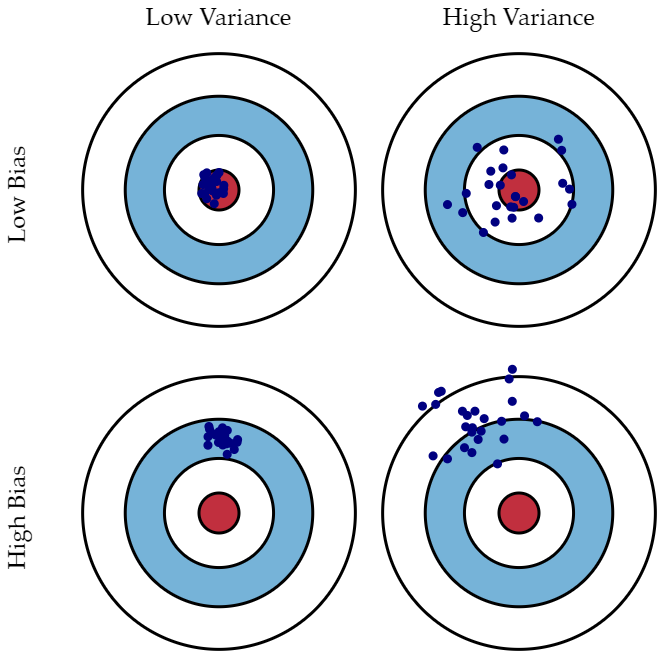
- 출처: http://scott.fortmann-roe.com

Bias vs Variance 곡선 시각화


In [1]:
import numpy as np
import plotly.graph_objects as go

complexity = np.linspace(0, 10, 100)

bias2 = (10 - complexity) ** 2 / 10
variance = (complexity) ** 2 / 10
error = bias2 + variance

fig = go.Figure()
fig.add_trace(go.Scatter(x=complexity, y=bias2, mode="lines", name="Bias² (편향 제곱)", line=dict(color="cyan", width=3)))
fig.add_trace(
    go.Scatter(x=complexity, y=variance, mode="lines", name="Variance (분산)", line=dict(color="magenta", width=3)))
fig.add_trace(go.Scatter(x=complexity, y=error, mode="lines", name="Total Error (총 오차)",
                         line=dict(color="yellow", width=3, dash="dot")))
fig.add_vline(x=5, line=dict(color="green", width=2, dash="dash"), annotation_text="균형점",
              annotation_position="top right")
fig.update_layout(title="Bias vs Variance Trade-off", xaxis_title="모델 복잡도", yaxis_title="오차 (Error)",
                  template="plotly_dark")
fig.show()

![image.png](attachment:bc201e7e-7fda-4b3c-a016-6837e3b17442.png)
- 출처: http://scott.fortmann-roe.com

| **구분**               | **Bias** | **Variance** | **상태** | **예시**      |
| -------------------- | -------- | ------------ | ------ | ----------- |
| Low Bias · Low Var   | ↓        | ↓            | 이상적    | 중심 근처에 모인 점 |
| Low Bias · High Var  | ↓        | ↑            | 과적합    | 중심 주변 흩어짐   |
| High Bias · Low Var  | ↑        | ↓            | 과소적합   | 한쪽에 몰림      |
| High Bias · High Var | ↑        | ↑            | 최악     | 멀리 흩어짐      |

### 잔차(Residual)

- 잔차 = 실제값 - 예측값
- 틀린거: 이거 줄이자

Bias 높으면 -> 과소적합 -> 너무 단순
Variance 높으면 -> 과적합 -> 너무 복잡

앙상블 -> 이 둘의 균형을 잡는 대표적인 방법 중 하나
- **Bagging** -> Variance를 줄이자: 모델 안정화
    - 모델을 여러개 만들어서 흔들림(분산)을 줄이는거
- **Boosting** -> Bais를 줄이자: 예측 정밀화
    - 잔차를 줄여서 **정확도 개선**

## 2) Voting (투표 기반 앙상블)

여러 모델의 예측을 **투표**로 결합하는 방법입니다.
- **Hard Voting**: 라벨 다수결
- **Soft Voting**: 예측 **확률** 평균
    - → 확신도까지 반영되어 **대체로** 더 안정적
- ※ Soft가 항상 우월한 건 아님(확률 품질이 낮은 모델이 섞이면 예외). 필요 시 **가중 투표** 또는 **확률 보정(CalibratedClassifierCV)**.

## 요약
1. 약점 보완: 특정 모델의 실수를 다른 모델이 보완
2. 안정성 향상: 여러 모델의 평균 -> 우연의 오차 상쇄
3. 직관적 구조: 쉬워여. 앙상블이 이런거구나 알 수 있는거다 말 씀을 드릴 있습니다.

In [2]:
import numpy as np, pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

wine = load_wine()
X, y = wine.data, wine.target
feature_names = wine.feature_names
target_names = wine.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("X shape:", X.shape)
print("class distribution:", np.bincount(y))

X shape: (178, 13)
class distribution: [59 71 48]


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

log_clf = Pipeline([("scaler", StandardScaler()),
                    ("clf", LogisticRegression(max_iter=5000, random_state=42))])

knn_clf = Pipeline([("scaler", StandardScaler()),
                    ("clf", KNeighborsClassifier(n_neighbors=7))])

dt_clf = DecisionTreeClassifier(max_depth=4, random_state=42)

In [4]:
from sklearn.ensemble import VotingClassifier

voting_hard = VotingClassifier(
    estimators=[("lr", log_clf), ("knn", knn_clf), ("dt", dt_clf)],
    voting="hard"
)

voting_soft = VotingClassifier(
    estimators=[("lr", log_clf), ("knn", knn_clf), ("dt", dt_clf)],
    # 확률 평균
    voting="soft"
)

# 가중 투표
# voting_soft_w = VotingClassifier(
#     estimators=[("lr", log_clf), ("knn", knn_clf), ("dt", dt_clf)],
#     voting="soft", weights=[2, 1, 1]
# )

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import plotly.figure_factory as ff
import plotly.express as px

models = {
    "Logistic": log_clf,
    "KNN": knn_clf,
    "DecisionTree": dt_clf,
    "Voting(Hard)": voting_hard,
    "Voting(Soft)": voting_soft
}

results = []
reports = {}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append([name, acc])
    reports[name] = classification_report(y_test, y_pred, target_names=target_names, digits=3, output_dict=True)
    print(f"\n== {name} ==")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    fig = ff.create_annotated_heatmap(z=cm, x=list(target_names), y=list(target_names),
                                      colorscale="Blues", showscale=True)
    fig.update_layout(title=f"Confusion Matrix — {name} (Counts)",
                      xaxis_title="Predicted", yaxis_title="Actual",
                      template="plotly_dark")
    fig.show()

    cm_norm = confusion_matrix(y_test, y_pred, normalize="true")
    fig2 = ff.create_annotated_heatmap(z=np.round(cm_norm, 3), x=list(target_names), y=list(target_names),
                                       colorscale="Blues", showscale=True)
    fig2.update_layout(title=f"Confusion Matrix — {name} (Normalized by True)",
                       xaxis_title="Predicted", yaxis_title="Actual",
                       template="plotly_dark")
    fig2.show()

df_results = pd.DataFrame(results, columns=["Model", "Test Accuracy"]).sort_values("Test Accuracy", ascending=False)
fig_bar = px.bar(df_results, x="Model", y="Test Accuracy",
                 title="Model Accuracy Comparison (Wine)",
                 template="plotly_dark", text="Test Accuracy")
fig_bar.update_traces(texttemplate="%{text:.3f}", textposition="outside")
fig_bar.update_layout(yaxis=dict(range=[0, 1]))
fig_bar.show()

df_results


== Logistic ==
Accuracy: 0.9722222222222222
              precision    recall  f1-score   support

     class_0      1.000     1.000     1.000        12
     class_1      0.933     1.000     0.966        14
     class_2      1.000     0.900     0.947        10

    accuracy                          0.972        36
   macro avg      0.978     0.967     0.971        36
weighted avg      0.974     0.972     0.972        36




== KNN ==
Accuracy: 1.0
              precision    recall  f1-score   support

     class_0      1.000     1.000     1.000        12
     class_1      1.000     1.000     1.000        14
     class_2      1.000     1.000     1.000        10

    accuracy                          1.000        36
   macro avg      1.000     1.000     1.000        36
weighted avg      1.000     1.000     1.000        36




== DecisionTree ==
Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

     class_0      1.000     0.917     0.957        12
     class_1      0.875     1.000     0.933        14
     class_2      1.000     0.900     0.947        10

    accuracy                          0.944        36
   macro avg      0.958     0.939     0.946        36
weighted avg      0.951     0.944     0.945        36




== Voting(Hard) ==
Accuracy: 0.9722222222222222
              precision    recall  f1-score   support

     class_0      1.000     1.000     1.000        12
     class_1      0.933     1.000     0.966        14
     class_2      1.000     0.900     0.947        10

    accuracy                          0.972        36
   macro avg      0.978     0.967     0.971        36
weighted avg      0.974     0.972     0.972        36




== Voting(Soft) ==
Accuracy: 0.9722222222222222
              precision    recall  f1-score   support

     class_0      1.000     1.000     1.000        12
     class_1      0.933     1.000     0.966        14
     class_2      1.000     0.900     0.947        10

    accuracy                          0.972        36
   macro avg      0.978     0.967     0.971        36
weighted avg      0.974     0.972     0.972        36



,Model,Test Accuracy
1,KNN,1.000000
0,Logistic,0.972222
3,Voting(Hard),0.972222
4,Voting(Soft),0.972222
2,DecisionTree,0.944444


In [6]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import plotly.graph_objects as go

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_data = wine.data
y = wine.target

cv_rows = []
for name, clf in models.items():
    scores = cross_val_score(clf, X_data, y, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_rows.append([name, scores.mean(), scores.std()])

cv_df = pd.DataFrame(cv_rows, columns=["Model", "CV mean acc", "CV std"]).sort_values("CV mean acc", ascending=False)
display(cv_df)

x_models = cv_df["Model"]
y_cv = cv_df["CV mean acc"].values
e_cv = cv_df["CV std"].values

fig_cv = go.Figure()
fig_cv.add_trace(go.Scatter(x=x_models, y=y_cv, mode="markers+lines", name="CV mean acc"))
fig_cv.add_trace(go.Scatter(
    x=list(x_models) + list(x_models[::-1]),
    y=list(y_cv + e_cv) + list((y_cv - e_cv)[::-1]),
    fill="toself", opacity=0.2, name="±1 std"
))
fig_cv.update_layout(title="Cross-Validation Accuracy (mean ± std)",
                     xaxis_title="Model", yaxis_title="CV Accuracy",
                     template="plotly_dark", yaxis=dict(range=[0, 1]))
fig_cv.show()

,Model,CV mean acc,CV std
0,Logistic,0.983333,0.013608
3,Voting(Hard),0.977460,0.027610
1,KNN,0.971905,0.025206
4,Voting(Soft),0.971905,0.025206
2,DecisionTree,0.882063,0.037655


## 3) Bagging (Bootstrap Aggregating)

- 동일한 모델을 **서로 다른 부트스트랩 샘플**로 여러 개 학습 → 평균/다수결
    - 서로 다른 데이터 셋을 기반으로 제각각 학습
- **Variance(분산)**을 줄여 과적합을 완화
- 주로 Decision Tree와 함께 사용
- OOB 점수로 검증셋 없이도 대략 성능 추정 가능

In [7]:
# Bagging — 2D 결정 경계 시각화 (Plotly 버전)
import numpy as np
import plotly.graph_objects as go
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

np.random.seed(42)

# 2D 합성 데이터
X2, y2 = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, class_sep=1.0, random_state=42)

# 단일 트리 vs Bagging 모델 학습
tree_single = DecisionTreeClassifier(max_depth=None, random_state=42).fit(X2, y2)
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=None,
                                                             random_state=42),                            n_estimators=100, # 모델 수, 많으면 많을수록 안정성 확보
                                                            max_samples=0.8, # 부트스트랩 샘플 크기
                                                            bootstrap=True,
                                                           random_state=42).fit(X2, y2)

# 결정 경계용 격자
pad = 1.0
xx, yy = np.meshgrid(
    np.linspace(X2[:, 0].min() - pad, X2[:, 0].max() + pad, 400),
    np.linspace(X2[:, 1].min() - pad, X2[:, 1].max() + pad, 400)
)
grid = np.c_[xx.ravel(), yy.ravel()]

Z_single = tree_single.predict(grid).reshape(xx.shape)
Z_bag = bagging.predict(grid).reshape(xx.shape)


# Plotly 시각화 함수
def plot_boundary_plotly(xx, yy, Z, X, y, title):
    fig = go.Figure()

    # 결정 경계
    fig.add_trace(go.Contour(
        x=xx[0], y=yy[:, 0], z=Z,
        showscale=False, opacity=0.3,
        contours_coloring="heatmap",
        name="decision boundary"
    ))

    # 데이터 산점도
    fig.add_trace(go.Scatter(
        x=X[:, 0], y=X[:, 1], mode="markers",
        marker=dict(size=8, color=y, colorscale="Viridis", line=dict(width=1, color="black")),
        name="data"
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Feature 1",
        yaxis_title="Feature 2",
        template="plotly_dark",
        width=600, height=500
    )
    fig.show()


# 실행
plot_boundary_plotly(xx, yy, Z_single, X2, y2, "Decision Tree (과적합 경향)")
plot_boundary_plotly(xx, yy, Z_bag, X2, y2, "Bagging (분산 감소·일반화 경향)")

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

bag_wine = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=None, random_state=42),
                             n_estimators=100, max_samples=0.8, bootstrap=True,
                             oob_score=True, random_state=42)
bag_wine.fit(X_train, y_train)
pred_bag = bag_wine.predict(X_test)
print("Bagging Test Acc:", accuracy_score(y_test, pred_bag))
print("OOB Score:", bag_wine.oob_score_)
print(classification_report(y_test, pred_bag, target_names=target_names, digits=3))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base = DecisionTreeClassifier(max_depth=None, random_state=42)
scores_base = cross_val_score(base, wine.data, wine.target, cv=cv, scoring="accuracy", n_jobs=-1)
scores_bag = cross_val_score(bag_wine, wine.data, wine.target, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Single Tree          CV mean±std: {scores_base.mean():.3f} ± {scores_base.std():.3f}")
print(f"Bagging(Tree×100)    CV mean±std: {scores_bag.mean():.3f} ± {scores_bag.std():.3f}")

Bagging Test Acc: 1.0
OOB Score: 0.9507042253521126
              precision    recall  f1-score   support

     class_0      1.000     1.000     1.000        12
     class_1      1.000     1.000     1.000        14
     class_2      1.000     1.000     1.000        10

    accuracy                          1.000        36
   macro avg      1.000     1.000     1.000        36
weighted avg      1.000     1.000     1.000        36

Single Tree          CV mean±std: 0.893 ± 0.038
Bagging(Tree×100)    CV mean±std: 0.966 ± 0.033


## 정리
- OOB 점수: 부트스트랩에서 적용 안된 샘플을 기반으로 내부 검증 -> 검증셋(test set)없이 대략적으로 성능 가능
- CV평균, 표준편차: 성능(평균), 안정성(표준편차)를 같이 보아야 함
- 혼동행렬도 같이 보면 좋습니다.

## Random Forest

###  개념
- **Random Forest = Bagging(트리 × N) + 특성 무작위화(`max_features`)**
- 목적: 트리끼리 **덜 닮게(correlation ↓)** 만들어 평균했을 때 **분산(Variance)을 더 강하게 ↓**
- 결과: 단일 트리의 **과적합(분산↑)**을 억제 → Bagging보다 **더 안정적이고 일반화 성능↑**


### 왜 `max_features`(특성 무작위화)가 필요한가?
- Bagging만 쓰면 **강력한 피처** 때문에 모든 트리가 비슷한 규칙으로 시작 → **복사본 평균** 효과
- RF는 **분기마다 고려 피처를 무작위로 제한** → 트리 간 관점 다양성↑ → **상관↓** → 평균 시 실수 상쇄 → **분산 ↓**


### 핵심 하이퍼파라미터
| 항목 | 설명 | WHY |
|---|---|---|
| `n_estimators` | 트리 개수(100~300+ 권장) | 많을수록 평균 효과↑, 분산↓ (시간·메모리 비용은 ↑) |
| `max_features` | 분기마다 고려 피처 수 | 작을수록 다양성↑, 상관↓ → RF 핵심 (너무 작으면 정보 손실) |
| `max_depth`/`min_samples_leaf` | 트리 복잡도 제어 | 깊으면 과적합↑, 적절 제한 → 일반화↑ |
| `oob_score=True` | Out-of-Bag 내장 검증 | 부트스트랩에서 빠진 샘플(≈36.8%)로 훈련 내부 성능 추정 |
| `n_jobs=-1` | 병렬 학습 | 모든 코어 사용 → 속도↑ |

> ⚠️ OOB vs CV: **성격이 다름**. 같은 축으로 비교하지 말고 **둘 다 참고**, 최종 평가는 **Test**에서.

### Bias–Variance
- 단일 트리: Variance ↑(불안정) → 과적합 위험
- Bagging: Variance ↓(평균 효과)
- Random Forest: Variance **↓↓**(트리 간 상관까지 낮춤)

In [9]:
import os, random, warnings
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine, make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.inspection import permutation_importance
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go

###  Single Tree vs Bagging (분산 감소)
**목표:** Bagging을 하면 결정 경계가 **덜 요동치고(분산↓)** 일반화가 좋아지는 걸 눈으로 확인

In [10]:
X2, y2 = make_classification(
    n_samples=500, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=1.0, random_state=42
)

tree_single = DecisionTreeClassifier(max_depth=None, random_state=42).fit(X2, y2)

bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=None),
    n_estimators=100, max_samples=0.8, bootstrap=True,
    n_jobs=-1, random_state=42
).fit(X2, y2)

xx, yy = np.meshgrid(
    np.linspace(X2[:, 0].min() - 1, X2[:, 0].max() + 1, 300),
    np.linspace(X2[:, 1].min() - 1, X2[:, 1].max() + 1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z_single = tree_single.predict(grid).reshape(xx.shape)
Z_bag = bagging.predict(grid).reshape(xx.shape)

fig1 = go.Figure(data=[go.Contour(x=xx[0], y=yy[:, 0], z=Z_single, showscale=False, opacity=0.3)])
fig1.add_scatter(x=X2[:, 0], y=X2[:, 1], mode="markers",
                 marker=dict(size=6, color=y2), showlegend=False)
fig1.update_layout(title="Decision Boundary — Single Tree (과적합 경향)",
                   template="plotly_dark", xaxis_title="x1", yaxis_title="x2")
fig1.show()

fig2 = go.Figure(data=[go.Contour(x=xx[0], y=yy[:, 0], z=Z_bag, showscale=False, opacity=0.3)])
fig2.add_scatter(x=X2[:, 0], y=X2[:, 1], mode="markers",
                 marker=dict(size=6, color=y2), showlegend=False)
fig2.update_layout(title="Decision Boundary — Bagging (분산 감소·일반화 경향)",

                   template="plotly_dark", xaxis_title="x1", yaxis_title="x2")

fig2.show()


In [16]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

X_tr, X_te, y_tr, y_te = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=42)

tree_single = DecisionTreeClassifier(max_depth=None, random_state=42).fit(X_tr, y_tr)
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=None),
                            n_estimators=100, max_samples=0.8, bootstrap=True,
                            n_jobs=-1, random_state=42).fit(X_tr, y_tr)

print("Single Tree  Test Acc:", accuracy_score(y_te, tree_single.predict(X_te)))

print("Bagging      Test Acc:", accuracy_score(y_te, bagging.predict(X_te)))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tree_cv = cross_val_score(DecisionTreeClassifier(max_depth=None, random_state=42),
                          X2, y2, cv=cv, scoring="accuracy", n_jobs=-1)
bag_cv = cross_val_score(BaggingClassifier(DecisionTreeClassifier(max_depth=None),
                                           n_estimators=100, max_samples=0.8, bootstrap=True, n_jobs=-1,
                                           random_state=42),
                         X2, y2, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Single Tree  CV mean±std: {tree_cv.mean():.3f} ± {tree_cv.std():.3f}")
print(f"Bagging      CV mean±std: {bag_cv.mean():.3f} ± {bag_cv.std():.3f}")

Single Tree  Test Acc: 0.94
Bagging      Test Acc: 0.9666666666666667
Single Tree  CV mean±std: 0.944 ± 0.022
Bagging      CV mean±std: 0.952 ± 0.021


### Wine 데이터: Single Tree vs Bagging vs Random Forest
**목표:** Test 정확도, OOB 점수, 정규화 혼동행렬, 교차검증 평균±표준편차로 **성능+안정성**을 수치로 비교

In [11]:
wine = load_wine()
X, y = wine.data, wine.target
target_names = wine.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

tree_single = DecisionTreeClassifier(max_depth=None, random_state=42)
tree_single.fit(X_train, y_train)
pred_single = tree_single.predict(X_test)
acc_single = accuracy_score(y_test, pred_single)

bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=None),
    n_estimators=100, max_samples=0.8, bootstrap=True,
    oob_score=True, n_jobs=-1, random_state=42
)
bag.fit(X_train, y_train)
pred_bag = bag.predict(X_test)
acc_bag = accuracy_score(y_test, pred_bag)
oob_bag = bag.oob_score_

rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt",
    bootstrap=True, oob_score=True, n_jobs=-1, random_state=42
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred_rf)
oob_rf = rf.oob_score_

display(pd.DataFrame({
    "Model": ["Single Tree", "Bagging(Tree×100)", "RandomForest(Tree×300)"],
    "Test Accuracy": [acc_single, acc_bag, acc_rf],
    "OOB (if available)": [np.nan, oob_bag, oob_rf]
}))

print("\n== Single Tree ==")
print(classification_report(y_test, pred_single, target_names=target_names, digits=3))
print("\n== Bagging (Tree×100) ==")
print("OOB Score:", oob_bag)
print(classification_report(y_test, pred_bag, target_names=target_names, digits=3))
print("\n== Random Forest (Tree×300) ==")
print("OOB Score:", oob_rf)
print(classification_report(y_test, pred_rf, target_names=target_names, digits=3))


def show_cm(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    fig = ff.create_annotated_heatmap(
        z=np.round(cm, 3), x=list(target_names), y=list(target_names),
        colorscale="Blues", showscale=True
    )
    fig.update_layout(title=f"Confusion Matrix (Normalized) — {name}",
                      xaxis_title="Predicted", yaxis_title="Actual",
                      template="plotly_dark")
    fig.show()


show_cm("Single Tree", y_test, pred_single)
show_cm("Bagging", y_test, pred_bag)
show_cm("RandomForest", y_test, pred_rf)

df_acc = pd.DataFrame({"Model": ["Single Tree", "Bagging(Tree×100)", "RandomForest(Tree×300)"],
                       "Test Accuracy": [acc_single, acc_bag, acc_rf]})
fig_bar = px.bar(df_acc, x="Model", y="Test Accuracy",
                 title="Wine — Test Accuracy", template="plotly_dark",
                 text="Test Accuracy")
fig_bar.update_traces(texttemplate="%{text:.3f}", textposition="outside")
fig_bar.update_layout(yaxis=dict(range=[0, 1]))
fig_bar.show()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_single = cross_val_score(tree_single, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
scores_bag = cross_val_score(bag, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
scores_rf = cross_val_score(rf, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

cv_df = pd.DataFrame({
    "Model": ["Single Tree", "Bagging(Tree×100)", "RandomForest(Tree×300)"],
    "CV mean acc": [scores_single.mean(), scores_bag.mean(), scores_rf.mean()],
    "CV std": [scores_single.std(), scores_bag.std(), scores_rf.std()]
}).sort_values("CV mean acc", ascending=False)
display(cv_df)

x = cv_df["Model"]
y = cv_df["CV mean acc"].values
e = cv_df["CV std"].values

fig_cv = go.Figure()
fig_cv.add_trace(go.Scatter(x=x, y=y, mode="markers+lines", name="CV mean acc"))
fig_cv.add_trace(go.Scatter(
    x=list(x) + list(x[::-1]),
    y=list(y + e) + list((y - e)[::-1]),
    fill="toself", opacity=0.2, name="±1 std"
))
fig_cv.update_layout(title="Wine — Cross-Validation Accuracy (mean ± std)",
                     xaxis_title="Model", yaxis_title="CV Accuracy",
                     template="plotly_dark", yaxis=dict(range=[0, 1]))
fig_cv.show()


,Model,Test Accuracy,OOB (if available)
0,Single Tree,0.944444,NaN
1,Bagging(Tree×100),1.000000,0.950704
2,RandomForest(Tree×300),1.000000,0.978873



== Single Tree ==
              precision    recall  f1-score   support

     class_0      1.000     0.917     0.957        12
     class_1      0.875     1.000     0.933        14
     class_2      1.000     0.900     0.947        10

    accuracy                          0.944        36
   macro avg      0.958     0.939     0.946        36
weighted avg      0.951     0.944     0.945        36


== Bagging (Tree×100) ==
OOB Score: 0.9507042253521126
              precision    recall  f1-score   support

     class_0      1.000     1.000     1.000        12
     class_1      1.000     1.000     1.000        14
     class_2      1.000     1.000     1.000        10

    accuracy                          1.000        36
   macro avg      1.000     1.000     1.000        36
weighted avg      1.000     1.000     1.000        36


== Random Forest (Tree×300) ==
OOB Score: 0.9788732394366197
              precision    recall  f1-score   support

     class_0      1.000     1.000     1.000   

,Model,CV mean acc,CV std
2,RandomForest(Tree×300),0.983016,0.022780
1,Bagging(Tree×100),0.966190,0.033135
0,Single Tree,0.893175,0.038028


### Feature Importance — Impurity vs Permutation
- **Impurity 기반** 중요도: 분할을 많이 일으킨/연속 피처에 편향 가능
- **Permutation** 중요도: 예측 성능 변화(Δaccuracy) 기반 → **해석 친화**(느리지만 신뢰↑)

In [12]:
importances_impurity = pd.Series(rf.feature_importances_, index=wine.feature_names).sort_values()
fig = px.bar(importances_impurity, orientation="h",
             title="Random Forest — Feature Importances (Impurity-based)",
             template="plotly_dark")
fig.update_layout(xaxis_title="importance", yaxis_title="feature")
fig.show()

perm = permutation_importance(rf, X_test, y_test, n_repeats=10, scoring="accuracy", n_jobs=-1, random_state=42)
importances_perm = pd.Series(perm.importances_mean, index=wine.feature_names).sort_values()
fig = px.bar(importances_perm, orientation="h",
             title="Random Forest — Permutation Importances (on Test)",
             template="plotly_dark")
fig.update_layout(xaxis_title="importance (Δaccuracy)", yaxis_title="feature")
fig.show()

### GridSearchCV 튜닝 — `n_estimators` / `max_depth` / `max_features`
- 그리드가 커지면 시간이 급증 → **좁게 시작 → 필요 시 확장**
- 불균형 데이터면 `scoring="f1_macro"`/`roc_auc_ovr"` 등 **문제에 맞는 지표** 사용

In [13]:
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [None, 10, 20, 30],
    "max_features": ["sqrt", "log2", 0.5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_base = RandomForestClassifier(bootstrap=True, oob_score=False, n_jobs=-1, random_state=42)

gs = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    # 불균형이면 'f1_macro' 추천
    scoring="accuracy",
    cv=cv, n_jobs=-1, refit=True, return_train_score=True
)
gs.fit(X_train, y_train)

print("best_params_:", gs.best_params_)
print("cv best_score_ (mean acc):", gs.best_score_)

result_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)
display(result_df[[
    "mean_test_score", "std_test_score", "param_n_estimators", "param_max_depth", "param_max_features"
]].head(10))

best_params_: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
cv best_score_ (mean acc): 0.9790640394088669


,mean_test_score,std_test_score,param_n_estimators,param_max_depth,param_max_features
0,0.979064,0.027713,100,None,sqrt
17,0.979064,0.027713,400,10,0.5
32,0.979064,0.027713,400,30,log2
31,0.979064,0.027713,200,30,log2
30,0.979064,0.027713,100,30,log2
29,0.979064,0.027713,400,30,sqrt
28,0.979064,0.027713,200,30,sqrt
27,0.979064,0.027713,100,30,sqrt
26,0.979064,0.027713,400,20,0.5
23,0.979064,0.027713,400,20,log2


### 최적 조합으로 재학습(+OOB(Out-Of-Bag)) & Test 평가
- CV 최고 조합으로 Train 전체 재학습
- `oob_score=True`로 **내장 검증**도 함께 확인
- Test에서 최종 성능 + 정규화 혼동행렬

In [14]:
best_params = gs.best_params_.copy()
rf_final = RandomForestClassifier(
    **best_params,
    bootstrap=True, oob_score=True, n_jobs=-1, random_state=42
)
rf_final.fit(X_train, y_train)

y_pred_final = rf_final.predict(X_test)
final_acc = accuracy_score(y_test, y_pred_final)

print("Final Test Accuracy:", final_acc)
print("OOB Score:", rf_final.oob_score_)
print(classification_report(y_test, y_pred_final, target_names=target_names, digits=3))

cm_norm = confusion_matrix(y_test, y_pred_final, normalize="true")
fig = ff.create_annotated_heatmap(
    z=np.round(cm_norm, 3), x=list(target_names), y=list(target_names),
    colorscale="Blues", showscale=True
)
fig.update_layout(title="Random Forest (Best) — Confusion Matrix (Normalized)",
                  xaxis_title="Predicted", yaxis_title="Actual",
                  template="plotly_dark")
fig.show()

Final Test Accuracy: 1.0
OOB Score: 0.9788732394366197
              precision    recall  f1-score   support

     class_0      1.000     1.000     1.000        12
     class_1      1.000     1.000     1.000        14
     class_2      1.000     1.000     1.000        10

    accuracy                          1.000        36
   macro avg      1.000     1.000     1.000        36
weighted avg      1.000     1.000     1.000        36



### ExtraTrees — 더 강한 무작위성 비교
- RF보다 **더 무작위**(분할 임계값까지 랜덤)
- 장점: 트리 간 상관 더 낮춰 **분산↓**, 학습 **속도↑**
- 단점: 임계값까지 무작위라 **Bias**가 다소 커질 수 있음
- 실무: RF와 **함께 후보로 비교**해 더 나은 쪽 선택

In [15]:
et = ExtraTreesClassifier(
    n_estimators=300, max_features="sqrt", bootstrap=False, n_jobs=-1, random_state=42
)
et.fit(X_train, y_train)
pred_et = et.predict(X_test)
acc_et = accuracy_score(y_test, pred_et)

compare_df = pd.DataFrame({"Model": ["RF(final)", "ExtraTrees"], "Test Accuracy": [final_acc, acc_et]})
display(compare_df)

,Model,Test Accuracy
0,RF(final),1.0
1,ExtraTrees,1.0


## 정리
- 단일 트리: Variance 높을 수 있음(불안정, 과적합)
- Bagging: Variance 낮춤(평균의 효과로 안정화)
- RF : 각각 트리를 다르게 진행(트리 상관관계 낮춤)
    - **서로 다른 나무(트리)**를 협력해서 숲을 만듬